# **How Hot Will Nigeria Be in 2025? A Personal Guide to Staying Indoors**

## **Introduction** 🌞

If you thought 2024 was *hot*, you're not alone. Remember those scorching afternoons when the difference in skin tan between your upper and lower arm made you question life choices? Yeah, me too. 😅

While I was busy hiding under shades, commuting from one place to another, I started wondering:
Which months are definitely stay-indoors months, and when can I safely step out without melting?*

To answer that, I performed a **climate analysis** for Nigeria for 2025 using **temperature projections** under the high-emission scenario (**SSP585**). The goal? To help you (and myself) identify months to schedule vacations, indoor days, or maybe just decide when to invest in a better fan. 

---

## **The Data** 📊

### The analysis uses:
- **WorldClim Climate Projections** ([CMIP6 data](https://www.worldclim.org)) for the years **2021–2040**.
- A focus on **Nigeria** under the **SSP585 scenario** (worst case, high emissions).
- Monthly average maximum temperatures for 2025.

---

## **Tools Used** 🛠️

- **Python**
- **Libraries**: `rasterio`, `geopandas`, `matplotlib`, `numpy`, `scipy`
- **Data Source**: WorldClim (GeoTIFF files)
- **Visualization**: Line plots and temperature heatmaps.

---

# Loading the Climate Projection Data and Shapefile
#The first step involved loading the global climate data (GeoTIFF) and Nigeria's shapefile for boundary extraction.
# Import and install necessary libraries
```python

In [3]:
!pip install rasterio geopandas shapely matplotlib numpy

  Using cached rasterio-1.4.3-cp312-cp312-win_amd64.whl.metadata (9.4 kB)
  Using cached geopandas-1.0.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached shapely-2.0.6-cp312-cp312-win_amd64.whl.metadata (7.2 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl.metadata (6.4 kB)
  Using cached pyogrio-0.10.0-cp312-cp312-win_amd64.whl.metadata (5.6 kB)
  Using cached pyproj-3.7.0-cp312-cp312-win_amd64.whl.metadata (31 kB)
   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/25.4 MB 660.6 kB/s eta 0:00:39
   ---------------------------------------- 0.0/25.4 MB 660.6 kB/s eta 0:00:39
   ---------------------------------------- 0.0/25.4 MB 660.6 kB/s eta 0:00:39
   ---------------------------------------- 0.0/25.4 MB 660.6 kB/s

In [5]:
import rasterio 
from rasterio.mask import mask
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import shape

In [7]:
# Define file paths
tif_path = "wc2.1_2.5m_tmax_ACCESS-CM2_ssp585_2021-2040.tif"  # Global climate data
shapefile_path = "ne_10m_admin_0_sovereignty/ne_10m_admin_0_sovereignty.shp"  # World shapefile containing Nigeria

In [9]:
# Load Nigeria's shapefile
global_shapes = gpd.read_file(shapefile_path)
nigeria_shape = global_shapes[global_shapes['SOVEREIGNT'] == 'Nigeria']

In [11]:
# Check geometry
print(nigeria_shape.geometry)
# I encountered an error loading the file cause ut contained **MultiPolygon** geometries that caused compatibility errors.
# Solution: Use `shapely.ops.unary_union` to simplify the MultiPolygon into a single geometry.

95    MULTIPOLYGON (((3.5964 11.69577, 3.64777 11.72...
Name: geometry, dtype: geometry


In [17]:
from shapely.ops import unary_union

In [19]:
# Convert MultiPolygon to a single Polygon
nigeria_geom = unary_union(nigeria_shape.geometry)
nigeria_shape = gpd.GeoDataFrame({'geometry': [nigeria_geom]}, crs="EPSG:4326")

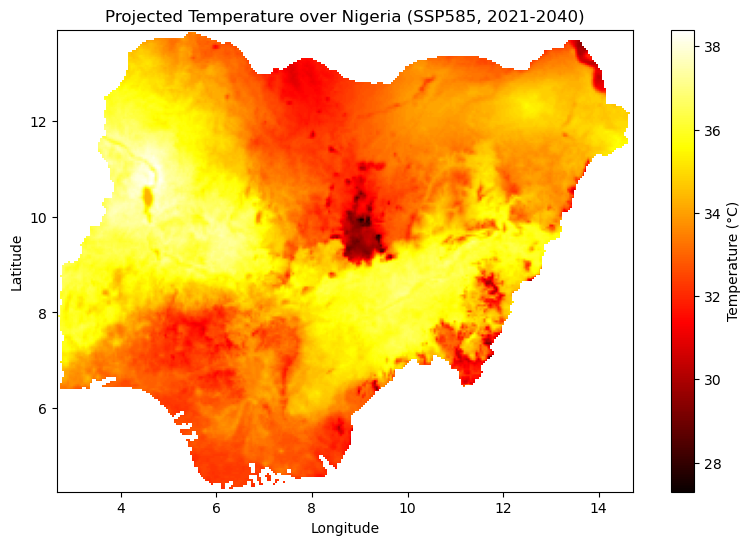

Clipped raster saved to nigeria_clipped_ssp585.tif


In [21]:
#Clipping the Global Climate Data to Nigeria's Boundary
#I masked the GeoTIFF file using Nigeria's geometry to extract the data for Nigeria only.
# Clip the raster file to Nigeria's boundary
with rasterio.open(tif_path) as src:
    nigeria_temp, nigeria_transform = mask(src, [nigeria_geom], crop=True)
    nigeria_meta = src.meta.copy()

# Update metadata for the clipped raster
nigeria_meta.update({
    "driver": "GTiff",
    "height": nigeria_temp.shape[1],
    "width": nigeria_temp.shape[2],
    "transform": nigeria_transform
})

# Plot the clipped temperature data for Nigeria
plt.figure(figsize=(10, 6))
plt.title("Projected Temperature over Nigeria (SSP585, 2021-2040)")
plt.imshow(nigeria_temp[0], cmap='hot', extent=[nigeria_transform[2], nigeria_transform[2] + nigeria_transform[0] * nigeria_temp.shape[2],
                                               nigeria_transform[5] + nigeria_transform[4] * nigeria_temp.shape[1], nigeria_transform[5]])
plt.colorbar(label="Temperature (°C)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Save the clipped raster
output_raster = "nigeria_clipped_ssp585.tif"
with rasterio.open(output_raster, "w", **nigeria_meta) as dest:
    dest.write(nigeria_temp)

print(f"Clipped raster saved to {output_raster}")

In [23]:
# Analyzing Monthly Temperature Data
#The raster file contains **12 bands**, where each band represents one month's average maximum temperature. We calculated the mean, min, and max temperatures for each month.

# Initialize lists to store monthly statistics
monthly_means, monthly_mins, monthly_maxs = [], [], []

# Load the clipped raster
with rasterio.open(output_raster) as src:
    for band in range(1, src.count + 1):  # Loop through all 12 bands
        data = src.read(band)
        data = data[~np.isnan(data)]  # Remove NoData values
        
        # Calculate statistics
        monthly_means.append(np.mean(data))
        monthly_mins.append(np.min(data))
        monthly_maxs.append(np.max(data))

# Print results
print("Monthly Mean Temperatures:", monthly_means)
print("Monthly Min Temperatures:", monthly_mins)
print("Monthly Max Temperatures:", monthly_maxs)

Monthly Mean Temperatures: [34.196857, 36.41889, 37.524807, 37.262917, 35.258183, 33.015625, 30.226843, 28.974882, 30.786938, 33.33913, 34.451836, 34.01244]
Monthly Min Temperatures: [27.3, 29.2, 28.5, 26.3, 25.0, 24.1, 22.5, 22.5, 23.3, 24.5, 26.0, 26.9]
Monthly Max Temperatures: [38.4, 40.8, 42.1, 44.0, 43.9, 42.2, 37.6, 35.0, 38.3, 41.0, 39.1, 37.9]


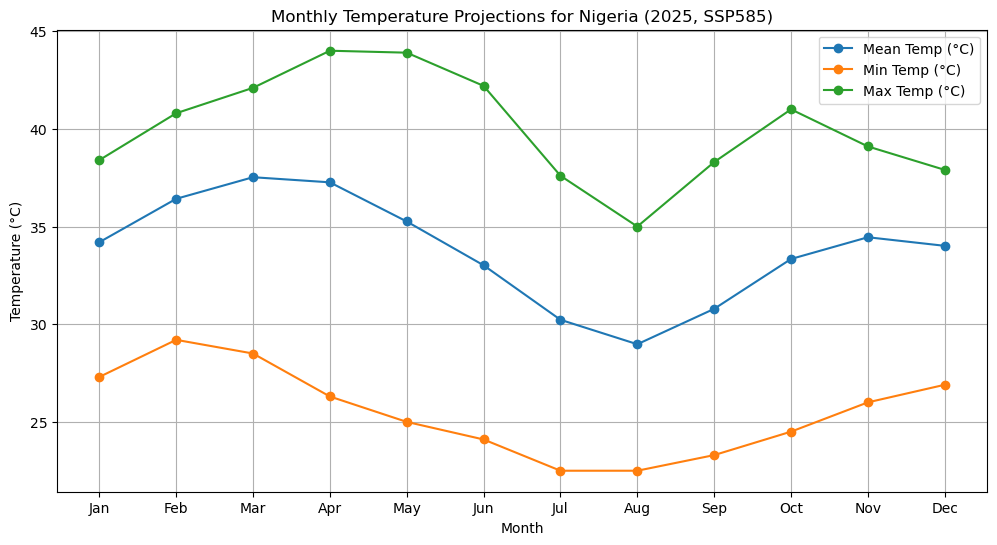

In [25]:
# Visualizing the Results
#We plotted the monthly mean, minimum, and maximum temperatures to identify patterns.

# Plot temperature trends
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.figure(figsize=(12, 6))
plt.plot(months, monthly_means, label="Mean Temp (°C)", marker='o')
plt.plot(months, monthly_mins, label="Min Temp (°C)", marker='o')
plt.plot(months, monthly_maxs, label="Max Temp (°C)", marker='o')

# Add labels and title
plt.title("Monthly Temperature Projections for Nigeria (2025, SSP585)")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid()
plt.show()

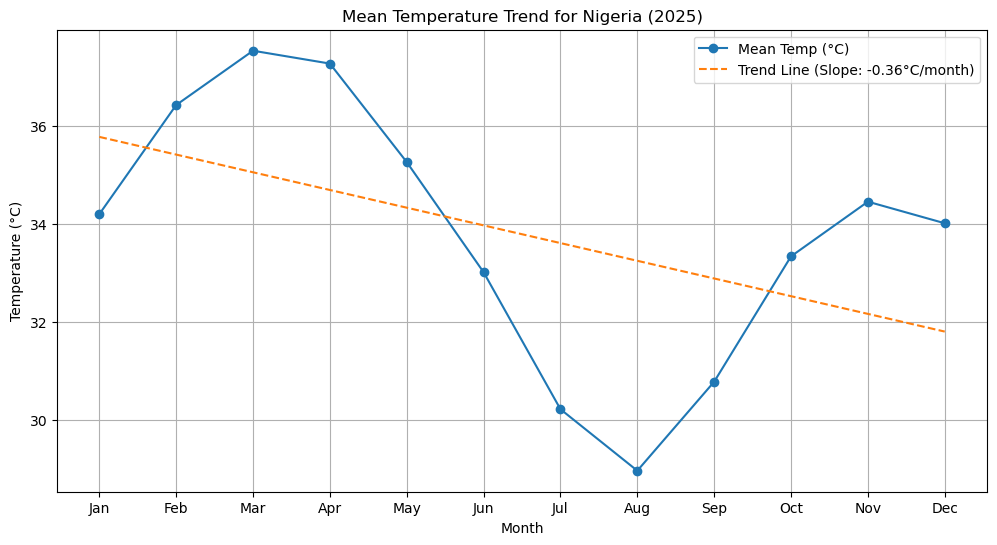

Slope: -0.36°C/month, R-squared: 0.23


In [27]:
#Trend Analysis
#We added a linear regression to identify the overall temperature trend.

from scipy.stats import linregress

# Fit a trend line to the mean temperatures
x = np.arange(1, 13)  # Months as numbers
slope, intercept, r_value, p_value, std_err = linregress(x, monthly_means)
trend_line = slope * x + intercept

# Plot the trend
plt.figure(figsize=(12, 6))
plt.plot(months, monthly_means, label="Mean Temp (°C)", marker="o")
plt.plot(months, trend_line, label=f"Trend Line (Slope: {slope:.2f}°C/month)", linestyle="--")
plt.title("Mean Temperature Trend for Nigeria (2025)")
plt.xlabel("Month")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid()
plt.show()

# Print trend details
print(f"Slope: {slope:.2f}°C/month, R-squared: {r_value**2:.2f}")

```

## **Insights**

- **Hottest Months**: March and April (Max ~44°C!). Stay indoors, people! ☀️
- **Coolest Months**: July and August (Avg ~29°C). This is when you can step out and enjoy *cooler* weather.
- **Overall Trend**: A noticeable rise in temperature leading up to April and again towards December.

---

## **Conclusion** 🚪

By analyzing climate projections, I now know which months to block off for **indoor activities** and when I can safely roam outdoors.

### **Key Takeaway**
If you're planning a trip or just managing your daily commute, avoid March–April unless you're okay turning into toast.

---

## **Repository Content** 📂

- `nigeria_temperature_analysis_2025.ipynb`: Full Python notebook with code and visualizations.
- `nigeria_clipped_ssp585.tif`: Clipped raster file for Nigeria.
- `nigeria_boundary.shp`: Shapefile for Nigeria's boundary.
- `README.md`: This documentation for easy reference.

Feel free to clone, explore, or expand on this project!

---

## **Summary of Errors and Fixes** ⚠️

- **MultiPolygon Issue**: Shapefiles sometimes contain MultiPolygons. Fixed by simplifying geometry using `unary_union`.
- **NoData Values**: Raster files often have empty regions. Removed with `~np.isnan(data)`.
- **Visualization Alignment**: Used `extent` and correct CRS to align temperature maps properly.

---

## **Final Insights** 📈

- **Hottest months**: **March and April** (Max ~44°C).
- **Coolest months**: **July and August** (Mean ~29°C).
- **Overall trend**: Temperatures rise steadily early in the year, dip mid-year, and climb again.

---

## **Project Files** 📂

- `nigeria_temperature_analysis_2025.ipynb`: Full code and results.
- `nigeria_boundary.shp`: Nigeria's boundary shapefile.
- `nigeria_clipped_ssp585.tif`: Clipped raster file.

---


### **Shapefile Loading Update**

I found a "better" way to load the shapefile using Fiona:

```python

In [65]:
!pip --default-timeout=100 install fiona

  Using cached fiona-1.10.1-cp312-cp312-win_amd64.whl.metadata (58 kB)
   ---------------------------------------- 0.0/24.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/24.5 MB 100.9 kB/s eta 0:04:03
   ---------------------------------------- 0.1/24.5 MB 192.5 kB/s eta 0:02:07
   ---------------------------------------- 0.1/24.5 MB 192.5 kB/s eta 0:02:07
   ---------------------------------------- 0.1/24.5 MB 187.3 kB/s eta 0:02:11
   ---------------------------------------- 0.1/24.5 MB 261.9 kB/s eta 0:01:33
   ---------------------------------------- 0.1/24.5 MB 303.9 kB/s eta 0:01:21
   ---------------------------------------- 0.2/24.5 MB 368.6 kB/s eta 0:01:06
   -----------------------

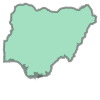

In [66]:
import fiona
import shapely.geometry as sg

# Extract specific Nigeria geometry using Fiona to avoid multi-part handling issues
nigeria_geom = None
with fiona.open(shapefile_path, "r") as shapefile:
    for feature in shapefile:
        if feature["properties"]["SOVEREIGNT"] == "Nigeria":
            nigeria_geom = sg.shape(feature["geometry"])
            break

# Confirm the extracted geometry for Nigeria
nigeria_geom

In [75]:
# Save Nigeria boundary shapefile
import os

# Define the folder path
nigeria_boundary_folder = "nigeria_boundary"

# Check if the folder exists, if not, create it
if not os.path.exists(nigeria_boundary_folder):
    os.makedirs(nigeria_boundary_folder)

# Save the shapefile
nigeria_shape.to_file(f"{nigeria_boundary_folder}/nigeria_boundary.shp")

print(f"Shapefile saved in: {nigeria_boundary_folder}")

Shapefile saved in: nigeria_boundary


```